In [0]:
%cd
%tensorflow_version 1.x

import os
import zipfile 
import tensorflow as tf

print(tf.__version__)

!git clone --quiet https://github.com/WimFlorijn/Mask-RCNN.git

%cd ~/Mask-RCNN

/root
TensorFlow 1.x selected.
1.15.2
/root/Mask-RCNN


In [0]:
!pip install -q PyDrive

from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
zip_ref = zipfile.ZipFile("/content/gdrive/My Drive/train_data.zip", 'r')
zip_ref.extractall("/tmp/traindata")
zip_ref.close()

['VW_LRN01_C_00506_000006362', 'VW_VKB03_A_00163_000000382', 'VW_BRC00_D_00230_000003359', 'VW_BRC00_A_00160_000000179', 'VW_LRN01_A_00510_000002882', 'VW_DTC02_B_00667_000000723', 'VW_DTC02_B_00547_000000602', 'VW_TBG01_S_00690_000009571', 'VW_LRN01_D_00171_000004474', 'VW_VKB03_A_00157_000000376', 'VW_NDN00_D_01123_000001897', 'VW_BER02_L_00138_000002878', 'VW_BIL01_E_01475_000007801', 'VW_LRN01_C_00204_000006053', 'VW_BER02_L_00117_000002857', 'VW_BRC00_E_00527_000002343', 'VW_NDN00_D_01000_000001736', 'VW_CVD00_C_00312_000006392', 'VW_NDN00_D_01059_000001800', 'VW_LRN01_C_00470_000006326', 'VW_TBG01_S_00448_000009326', 'VW_DNK00_G_00237_000006991', 'VW_CVD00_C_00153_000006232', 'VW_DTC02_B_00221_000000262', 'VW_BRC00_E_00051_000001854', 'VW_BER02_L_00139_000002879', 'VW_DNK00_O_01150_000006464', 'VW_BRC00_A_00007_000000007', 'VW_CVD00_C_00435_000006518', 'VW_BIL01_E_00772_000007107', 'VW_BRC00_E_00572_000002388', 'VW_LRN01_D_00170_000004473', 'VW_TBG01_S_00688_000009569', 'VW_VKB03

In [0]:
import os
import re
import sys
import cv2
import math
import time
import random
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath('../../')

# Import Mask RCNN
sys.path.append(ROOT_DIR)
import mrcnn.model as modellib

from mrcnn import utils
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.config import Config

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = '/tmp/snapshot'

Using TensorFlow backend.


... done downloading pretrained model!


In [0]:
class SketchConfig(Config):

    # Give the configuration a recognizable name
    NAME = "sketch"

    BACKBONE='resnet50'

    SAVE_INTERVAL = 2
    USE_MINI_MASK = True

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + measurement + parcel number

    # Use small images for faster training. Set the limits of the small side
    # the large side, which determines the image shape.
    IMAGE_MIN_DIM = 768
    IMAGE_MAX_DIM = 1280

    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.7

    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3
    
    # Percent of positive ROIs used to train classifier/mask heads
    ROI_POSITIVE_RATIO = 0.33

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 24, 32, 40)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 400

    # Epoch size should approximate train set
    STEPS_PER_EPOCH = 2000

    # Epoch size should approximate validation set
    VALIDATION_STEPS = 100

config = SketchConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1280
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  768
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1280 1280    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [0]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """

    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))

    return ax

In [0]:
class SketchDataset(utils.Dataset):

    def load_sketch(self, image_ids):
        self.add_class("sketch", 1, "measurement")
        self.add_class("sketch", 2, "parcel_number")
        self.add_class("sketch", 3, "building")

        for image_id in image_ids:
          path = os.path.join(dataset_dir, image_id, "image.png")
          self.add_image("sketch", image_id=image_id, path=path)

    def load_mask(self, image_id):
        # Get mask directory from image path
        dataset_dir = '/tmp/traindata'
        
        info = self.image_info[image_id]
        
        # Get mask directory from image path
        mask_dirs = ['building_masks', 'measurement_masks',
                     'parcel_number_masks']
        
        # Read mask files from .png image
        masks, labels = [], []
        mask_shape = (config.IMAGE_MAX_DIM, config.IMAGE_MIN_DIM)
        for i, name in enumerate(mask_dirs):
            path_dir = os.path.dirname(info['path'])
            mask_dir = os.path.join(dataset_dir, path_dir, name)
            if os.path.exists(mask_dir) and len(os.listdir(mask_dir)) != 0:
                for f in next(os.walk(mask_dir))[2]:
                    mask_img=np.zeros(mask_shape, dtype=np.uint8)
                    m = np.load(os.path.join(mask_dir, f))
                    mask_img[m[0], m[1]] = 1
                    masks.append(mask_img)
                    labels.append(i + 1)
        
        if len(masks):
            masks = np.stack(masks, axis=-1)
            labels = np.asarray(labels, dtype=np.int32)
        else:
            masks = np.zeros((config.IMAGE_MAX_DIM, config.IMAGE_MIN_DIM, 0),
                             dtype=np.uint8)
            labels = np.array([])

        return masks, labels

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "sketch":
            return info["id"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [0]:
dataset_dir = '/tmp/traindata'
image_ids = next(os.walk(dataset_dir))[1]

# Add images
random.shuffle(image_ids)

split = .95
image_ids_length = len(image_ids)
split_idx = int(image_ids_length * split)
train_ids, val_ids = image_ids[:split_idx], image_ids[split_idx:]

# Training dataset
dataset_train = SketchDataset()
dataset_train.load_sketch(train_ids)
dataset_train.prepare()

# Validation dataset
dataset_val = SketchDataset()
dataset_val.load_sketch(val_ids)
dataset_val.prepare()

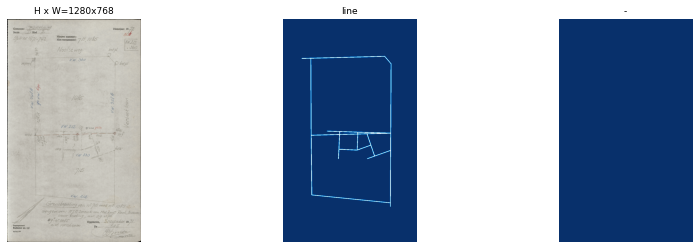

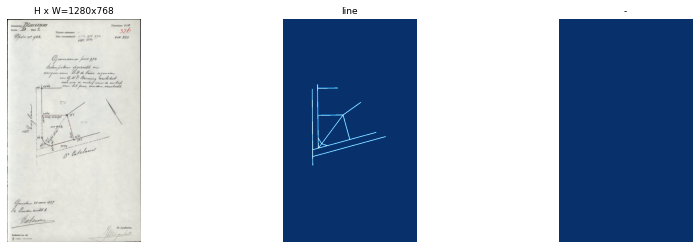

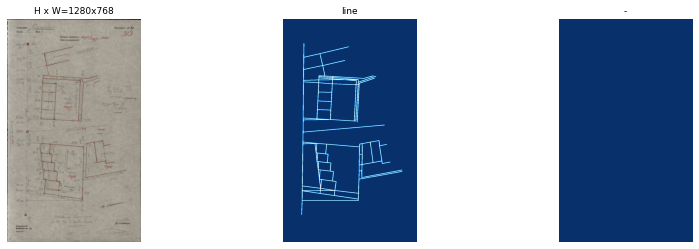

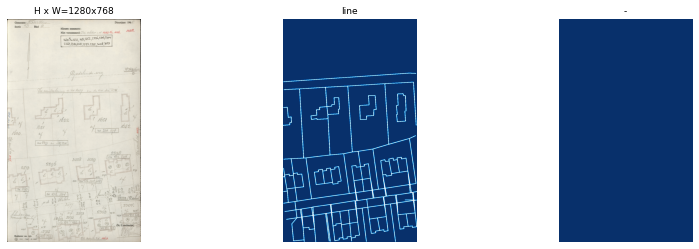

In [0]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids,
                                dataset_train.class_names, limit=3)

In [0]:
# Create model in training mode
try:
    del model
except:
    pass

model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [0]:
# Which weights to start with?
init_with = None  # imagenet, coco, last or None

if init_with == "imagenet":
    # Local path to trained weights file
    COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
    if not os.path.exists(COCO_MODEL_PATH):
        utils.download_trained_weights(COCO_MODEL_PATH)
    
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [0]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12536203728953717120, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1667482360193631589
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1994034169660342452
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15956099072
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14266005069130008582
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [0]:
import keras

# Train the head branches

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0)
model_checkpoint = ModelCheckpoint(
    '/content/gdrive/My Drive/rcnn_snapshot/weights_initial.h5',
    monitor='val_loss', save_best_only=True)

model.train(dataset_train,
            dataset_val, 
            learning_rate=config.LEARNING_RATE,
            epochs=config.LEARNING_RATE,
            layers='heads',
            custom_callbacks=[early_stopping, model_checkpoint])


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/gdrive/My Drive/snapshot/sketch20200406T1219/mask_rcnn_sketch_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrc

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/300
1000/1000 [==============================] - 469s 469ms/step - loss: 22.0746 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 21.5104 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.3623 - mrcnn_mask_loss: 0.1329 - val_loss: 18.1479 - val_rpn_class_loss: 0.0189 - val_rpn_bbox_loss: 17.6497 - val_mrcnn_class_loss: 0.0282 - val_mrcnn_bbox_loss: 0.3260 - val_mrcnn_mask_loss: 0.1252

Epoch 2/300
1000/1000 [==============================] - 432s 432ms/step - loss: 16.8161 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 16.3791 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.2611 - mrcnn_mask_loss: 0.1262 - val_loss: 16.8540 - val_rpn_class_loss: 0.0190 - val_rpn_bbox_loss: 16.3551 - val_mrcnn_class_loss: 0.0331 - val_mrcnn_bbox_loss: 0.3138 - val_mrcnn_mask_loss: 0.1330
Epoch 3/300
1000/1000 [==============================] - 432s 432ms/step - loss: 15.2921 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 14.8952 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.2312 - mrcnn_mask_loss: 0.1238 - val

Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Process ForkPoolWorker-4:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run


KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/root/Mask-RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/root/Mask-RCNN/mrcnn/model.py", line 1220, in load_image_gt
    mask = utils.resize_mask(mask, scale, padding, crop)
KeyboardInterrupt
  File "/root/Mask-RCNN/mrcnn/utils.py", line 508, in resize_mask
    mask = scipy.ndimage.zoom(mask, zoom=[scale, scale, 1], order=0)
  File "/usr/local/lib/python3.6/dist-packages/scipy/ndimage/interpolation.py", line 615, in zoom
    _nd_image.zoom_shift(filtered, zoom, None, output, order, mode, cval)
KeyboardInterrupt


KeyboardInterrupt: ignored

In [0]:
# Finetuning step 1

model_checkpoint = ModelCheckpoint(
    '/content/gdrive/My Drive/rcnn_snapshot/weights_fine_1.h5',
    monitor='val_loss', save_best_only=True)

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE,
            epochs=300, layers='all', custom_callbacks=[early_stopping, model_checkpoint])

In [0]:
# Finetuning step 2

model_checkpoint = ModelCheckpoint(
    '/content/gdrive/My Drive/rcnn_snapshot/weights_fine_2.h5',
    monitor='val_loss', save_best_only=True)

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=300, layers='all', custom_callbacks=[early_stopping, model_checkpoint])

In [0]:
class InferenceConfig(SketchConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Load trained weights
model_path = '/content/gdrive/My Drive/rcnn_snapshot/weights_fine_2.h5'
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/gdrive/My Drive/snapshot/sketch20200330T1157/mask_rcnn_sketch_0010.h5






Re-starting from epoch 10


original_image           shape: (1280, 1280, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 1280.00000  int64
gt_class_id              shape: (11,)                 min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (11, 4)               min:  321.00000  max:  856.00000  int32
gt_mask                  shape: (1280, 1280, 11)      min:    0.00000  max:    1.00000  uint8


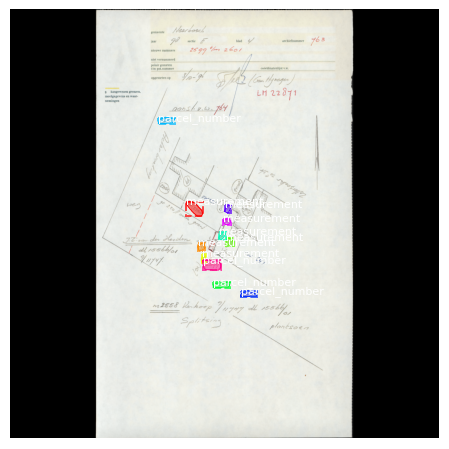

Processing 1 images
image                    shape: (1280, 1280, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1280, 1280, 3)    min: -123.70000  max:  141.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1280.00000  int64
anchors                  shape: (1, 409200, 4)        min:   -0.02211  max:    1.00259  float32


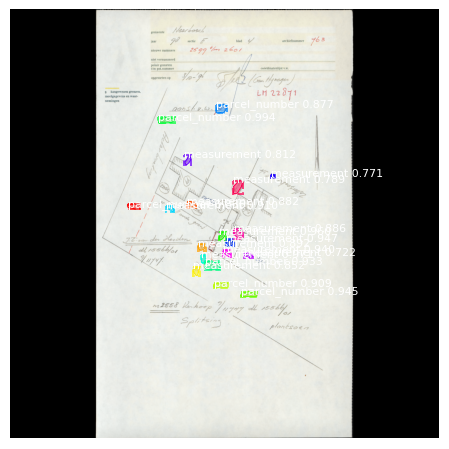

In [0]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
masked_image = visualize.display_instances(
    original_image, r['rois'], r['masks'], r['class_ids'],
    dataset_val.class_names, r['scores'], ax=get_ax())

from skimage.io import imsave

masked_image = np.invert(masked_image.astype(np.uint8)) * 255
imsave(fname='/content/gdrive/My Drive/out.png', arr=masked_image)